In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
train = pd.read_csv('combined_train.csv')
train.head()

,Species,Longitude,Latitude,Station,Date,Tavg,WetBulb,PrecipTotal,AvgSpeed,WnvPresent
0,CULEX PIPIENS/RESTUANS,-87.800991,41.954690,1.0,2007-05-29,74.0,65.0,0.0,6.5,0
1,CULEX RESTUANS,-87.800991,41.954690,1.0,2007-05-29,74.0,65.0,0.0,6.5,0
2,CULEX RESTUANS,-87.769279,41.994991,1.0,2007-05-29,74.0,65.0,0.0,6.5,0
3,CULEX PIPIENS/RESTUANS,-87.824812,41.974089,1.0,2007-05-29,74.0,65.0,0.0,6.5,0
4,CULEX RESTUANS,-87.824812,41.974089,1.0,2007-05-29,74.0,65.0,0.0,6.5,0


In [3]:
test = pd.read_csv('combined_test.csv')
test.head()

,Species,Longitude,Latitude,Station,Date,Tavg,WetBulb,PrecipTotal,AvgSpeed
0,CULEX PIPIENS/RESTUANS,-87.800991,41.95469,1.0,2008-06-11,74.0,64.0,0.0,10.0
1,CULEX RESTUANS,-87.800991,41.95469,1.0,2008-06-11,74.0,64.0,0.0,10.0
2,CULEX PIPIENS,-87.800991,41.95469,1.0,2008-06-11,74.0,64.0,0.0,10.0
3,CULEX SALINARIUS,-87.800991,41.95469,1.0,2008-06-11,74.0,64.0,0.0,10.0
4,CULEX TERRITANS,-87.800991,41.95469,1.0,2008-06-11,74.0,64.0,0.0,10.0


In [4]:
spray = pd.read_csv('assets/input/spray.csv')

In [5]:
spray.Date.map(lambda x: x[:4]).unique()

array(['2011', '2013'], dtype=object)

In [6]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


# Dummying Categorical Variables

In [7]:
def leveller(train, test):
    tr_features = set(train.columns)
    te_features = set(test.columns)
    for missing_col in tr_features - te_features:
        test[missing_col] = 0
    return train, test[train.columns]

In [8]:
def split_species(train, test):
    train_full = pd.get_dummies(train, columns = ['Species'])
    test_full = pd.get_dummies(test, columns = ['Species'])
    return train_full, test_full

In [9]:
train, test = split_species(train, test)

In [10]:
train, test = leveller(train, test)

In [11]:
train.columns

Index(['Longitude', 'Latitude', 'Station', 'Date', 'Tavg', 'WetBulb',
       'PrecipTotal', 'AvgSpeed', 'WnvPresent', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object')

In [12]:
test.columns

Index(['Longitude', 'Latitude', 'Station', 'Date', 'Tavg', 'WetBulb',
       'PrecipTotal', 'AvgSpeed', 'WnvPresent', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object')

# Visualizations

todo: plot univariate distributions for numerics / categoricals

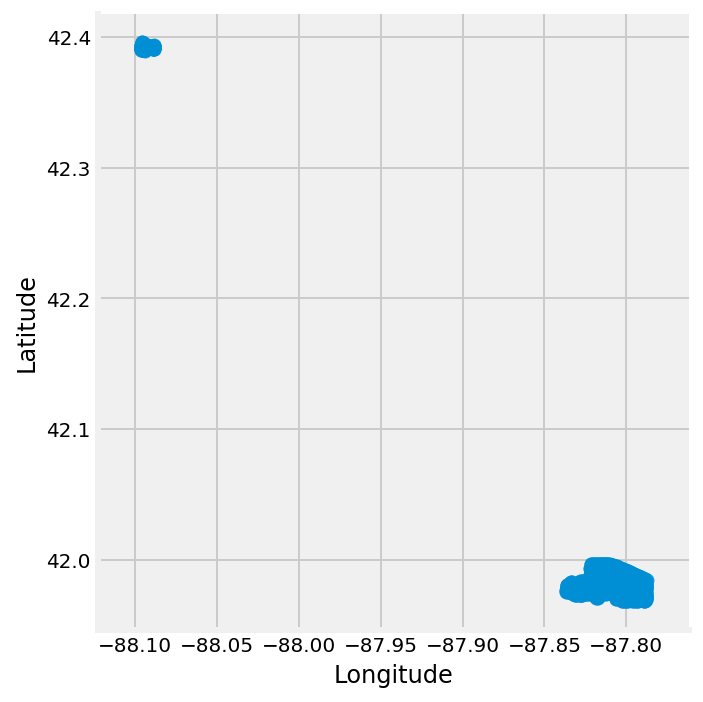

In [13]:
sns.lmplot('Longitude', 'Latitude', data = spray[(spray['Date'].map(lambda x: x[:4]) == '2011')],fit_reg = False)

In [14]:
train.Date.map(lambda x: x[:4]).unique()

array(['2007', '2009', '2011', '2013'], dtype=object)

In [16]:
train.head()

,Longitude,Latitude,Station,Date,Tavg,WetBulb,PrecipTotal,AvgSpeed,WnvPresent,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,-87.800991,41.954690,1.0,2007-05-29,74.0,65.0,0.0,6.5,0,0,0,1,0,0,0,0
1,-87.800991,41.954690,1.0,2007-05-29,74.0,65.0,0.0,6.5,0,0,0,0,1,0,0,0
2,-87.769279,41.994991,1.0,2007-05-29,74.0,65.0,0.0,6.5,0,0,0,0,1,0,0,0
3,-87.824812,41.974089,1.0,2007-05-29,74.0,65.0,0.0,6.5,0,0,0,1,0,0,0,0
4,-87.824812,41.974089,1.0,2007-05-29,74.0,65.0,0.0,6.5,0,0,0,0,1,0,0,0


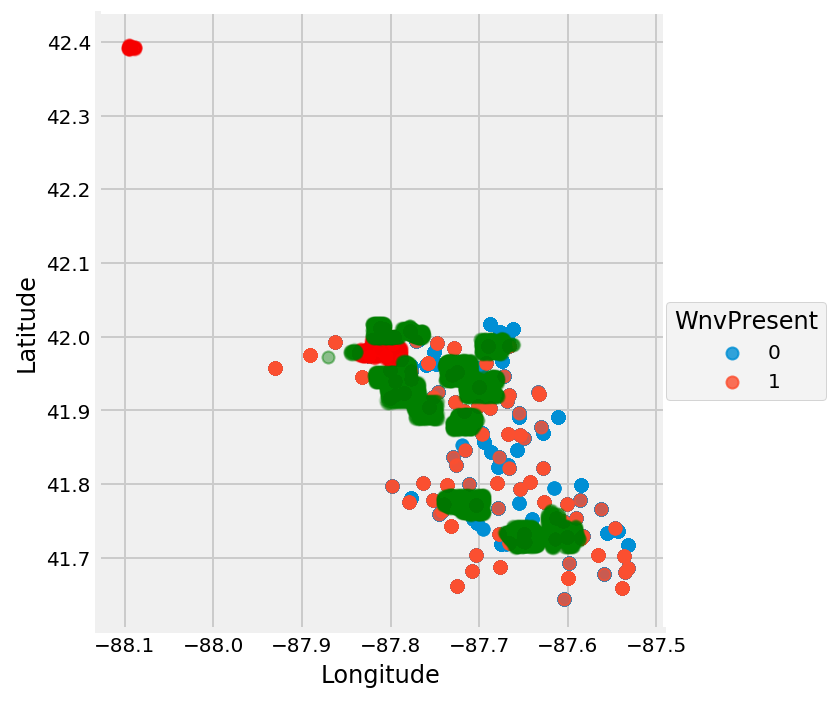

In [17]:
g = sns.lmplot('Longitude','Latitude',data = train, hue = 'WnvPresent',fit_reg = False,)
sns.regplot('Longitude', 'Latitude', data = spray[(spray['Date'].map(lambda x: x[:4]) == '2011')],fit_reg = False,color = 'r', scatter_kws={'alpha':0.1})
sns.regplot('Longitude', 'Latitude', data = spray[(spray['Date'].map(lambda x: x[:4]) == '2013')],fit_reg = False,color = 'g',scatter_kws={'alpha':0.1})

In [ ]:
plt.figure(figsize = (12, 12))
ax = plt.gca()
ax.scatter()

Text(0.5,1,'Test')

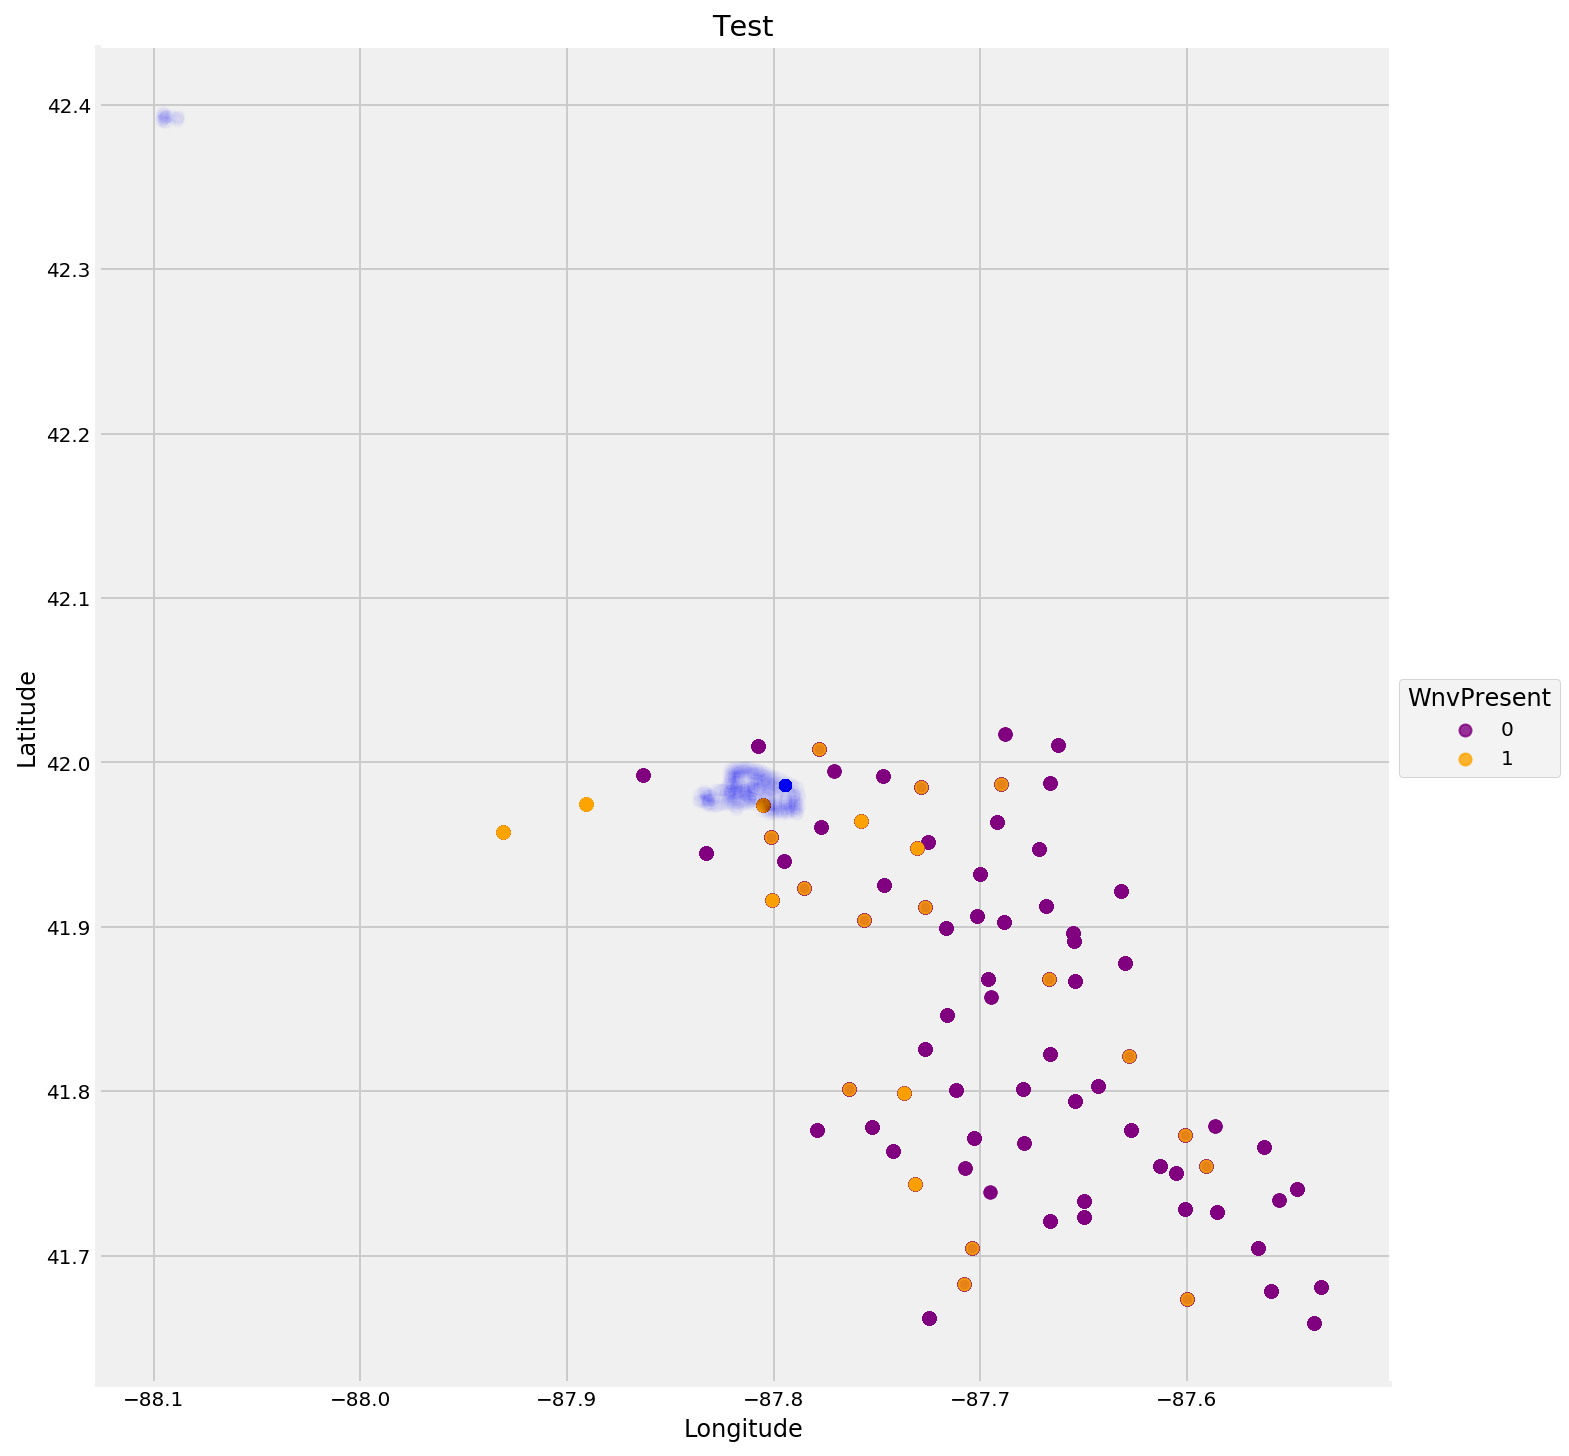

In [23]:
g = sns.lmplot('Longitude','Latitude',data = train[train['Date'].map(lambda x: x[:4])=='2011'], hue = 'WnvPresent',palette = {0:'purple',1:'orange'},fit_reg = False,size = 10)
sns.regplot('Longitude', 'Latitude', data = spray[(spray['Date'].map(lambda x: x[:4]) == '2011')],fit_reg = False,color = 'b', scatter_kws={'alpha':0.005})
g.fig.gca().set_title("Test")

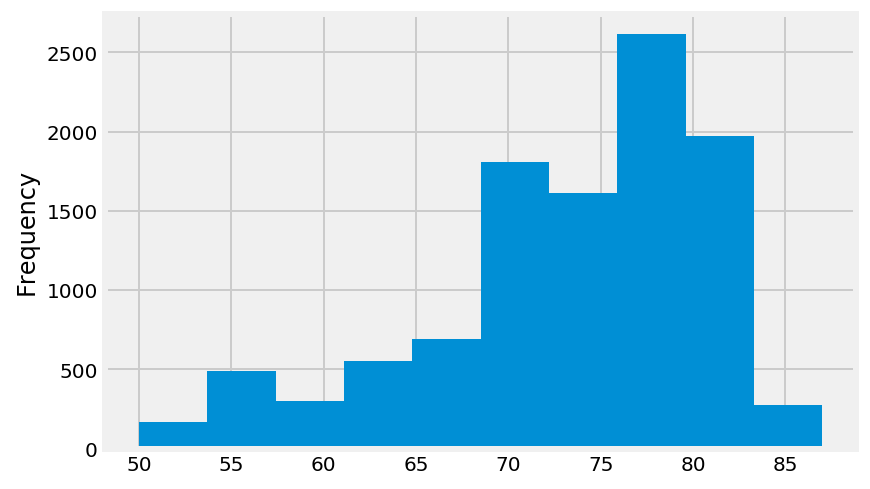

In [24]:
train['Tavg'].plot(kind='hist')

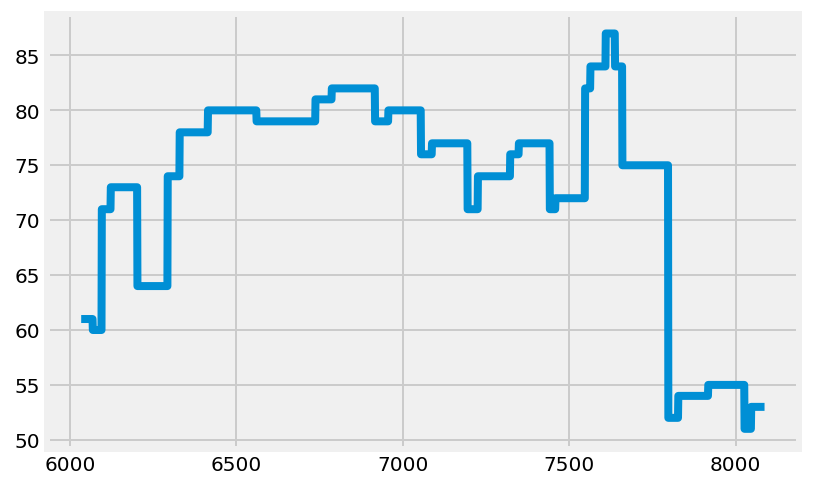

In [25]:
train[train['Date'].map(lambda x: x[:4]) == '2011']['Tavg'].plot()

In [26]:
train['Year'] = train['Date'].map(lambda x: x[:4])

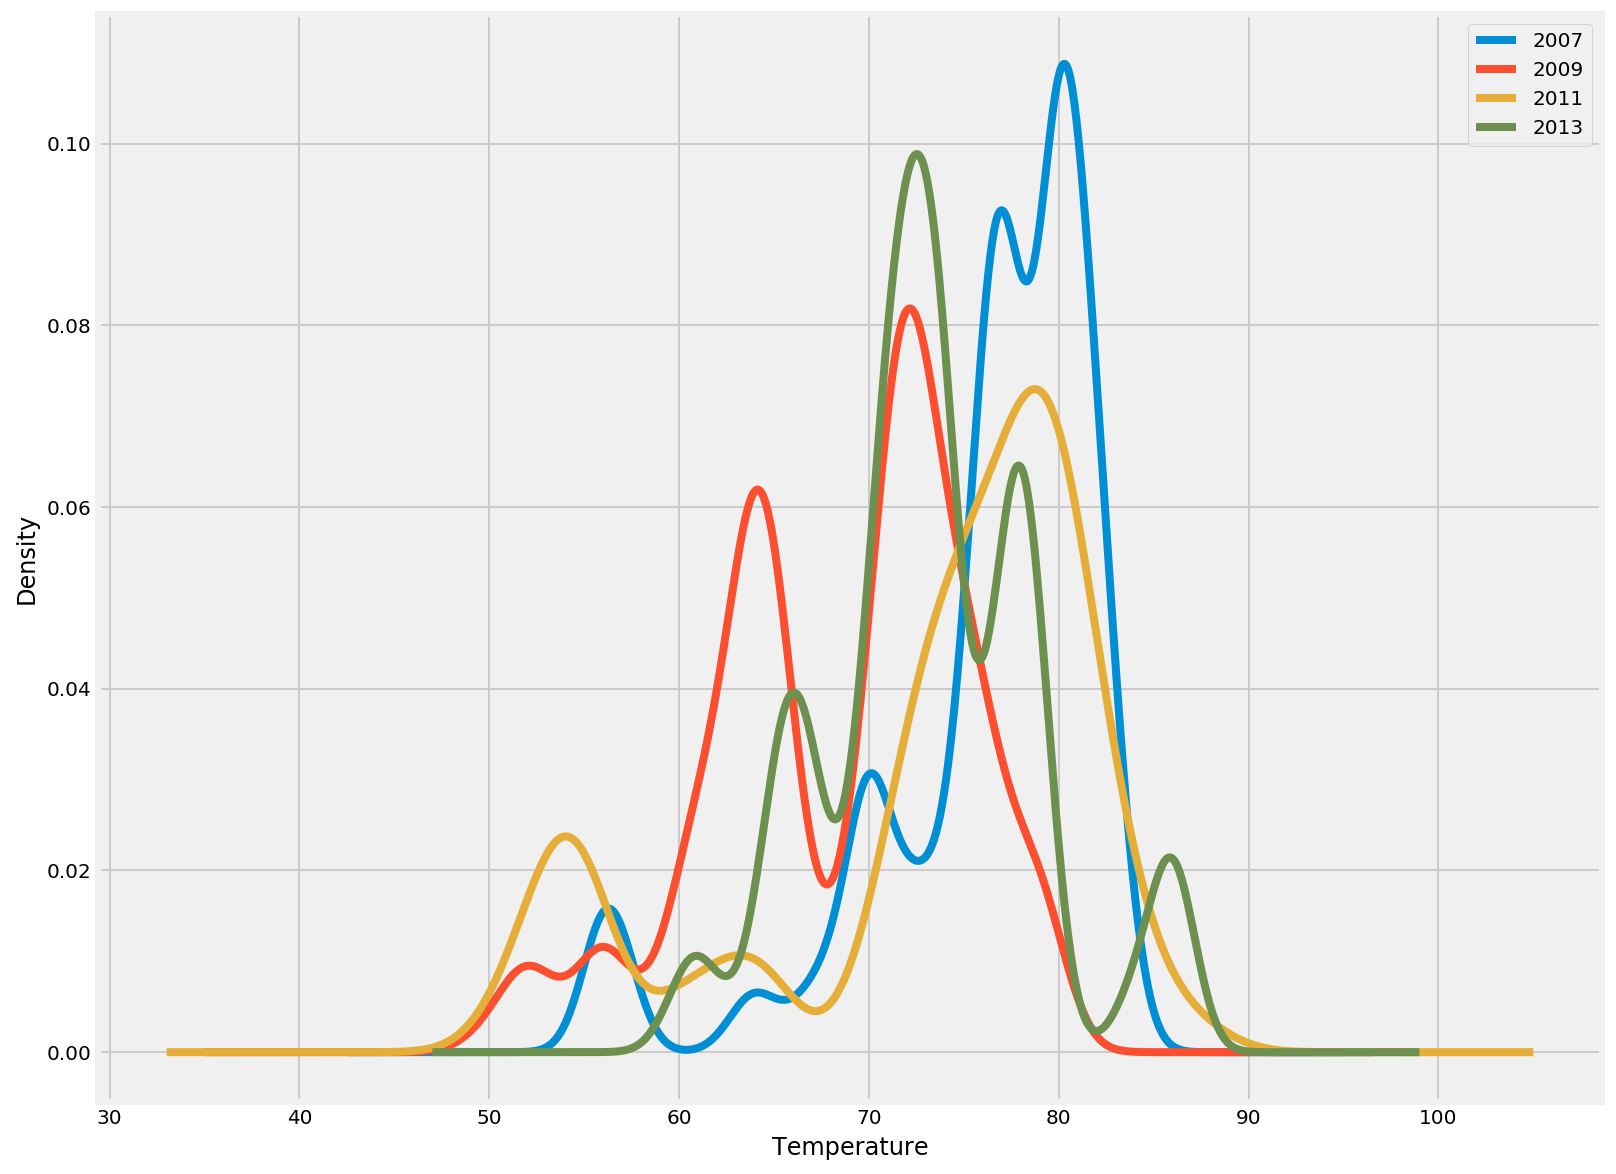

In [27]:
# Careful not to misinterpret these histograms
plt.figure(figsize = (12,10))
train.groupby('Year')['Tavg'].plot(kind = 'kde')
ax = plt.gca()
ax.set_xlabel("Temperature")
plt.legend()

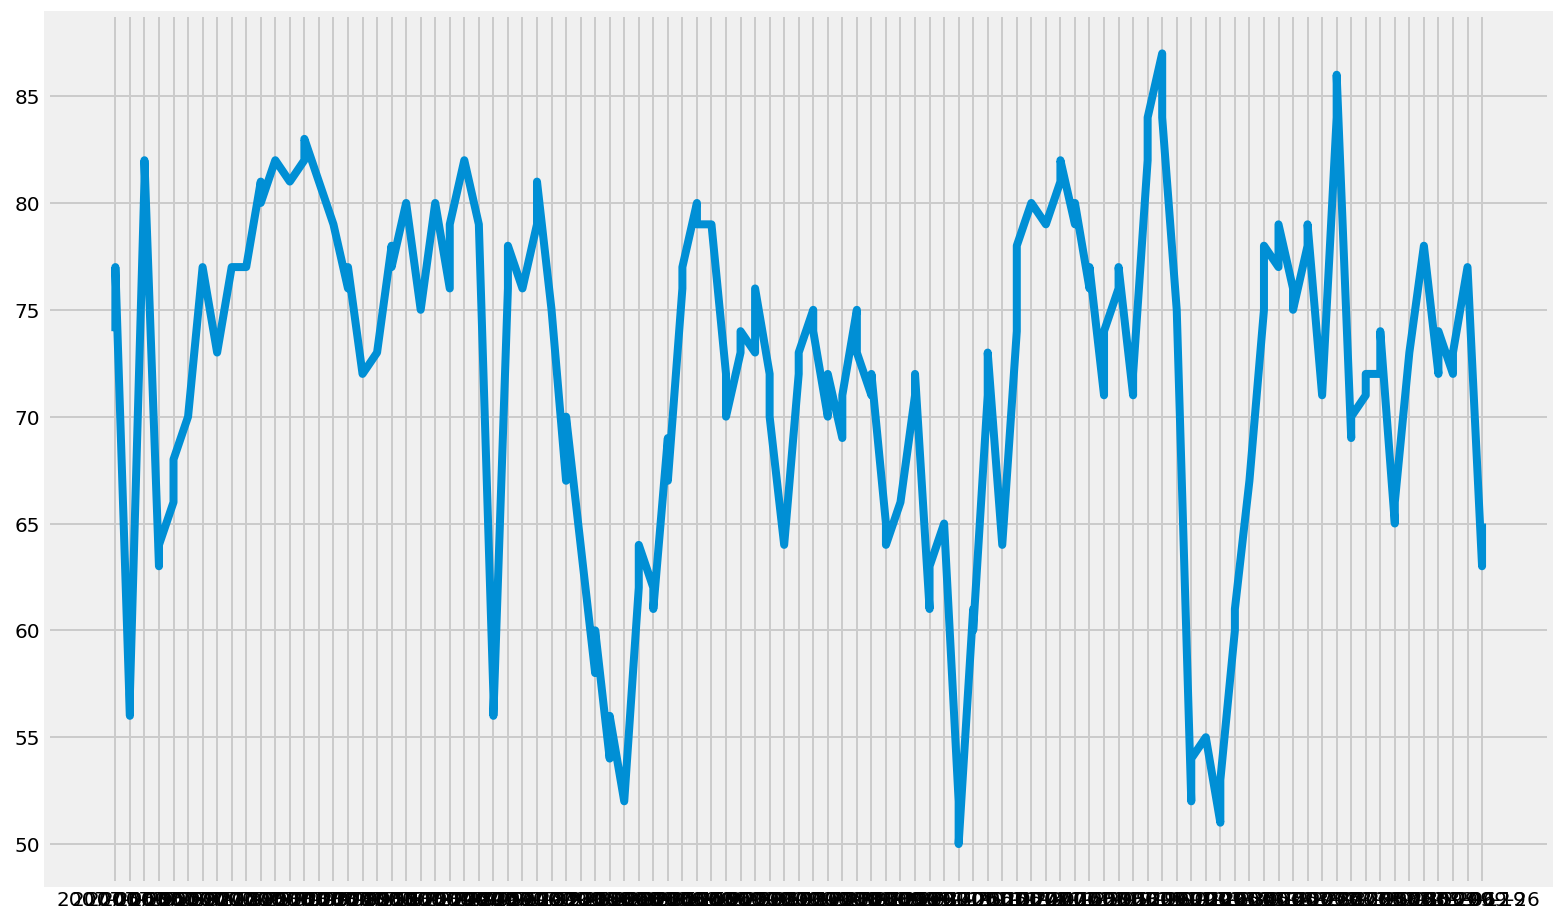

In [28]:
plt.figure(figsize = (12,8))
ax = plt.gca()
ax.plot(train['Date'], train['Tavg'])

In [11]:
train.columns

Index(['Longitude', 'Latitude', 'Station', 'Date', 'Tavg', 'WetBulb',
       'PrecipTotal', 'AvgSpeed', 'WnvPresent', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object')

In [12]:
species = [col for col in train.columns if col.startswith("Species")]
species

['Species_CULEX ERRATICUS',
 'Species_CULEX PIPIENS',
 'Species_CULEX PIPIENS/RESTUANS',
 'Species_CULEX RESTUANS',
 'Species_CULEX SALINARIUS',
 'Species_CULEX TARSALIS',
 'Species_CULEX TERRITANS']

In [13]:
train[species]

,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0
7,0,0,0,1,0,0,0
8,0,0,1,0,0,0,0
9,0,0,0,1,0,0,0


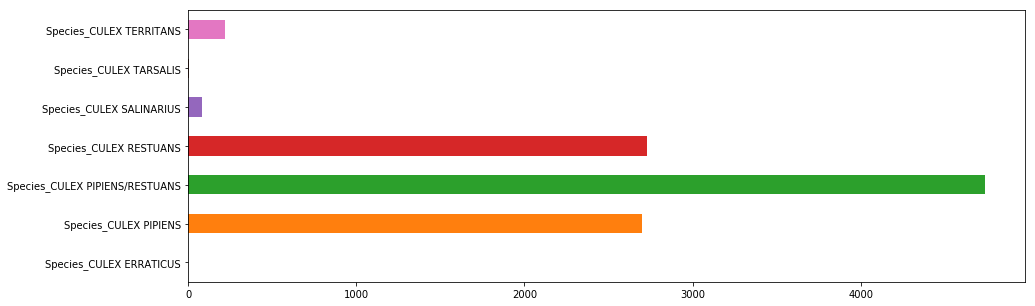

In [18]:
# Plot of species counts
plt.figure(figsize = (15, 5))
train[species].sum().plot(kind='barh')

In [19]:
train.columns

Index(['Longitude', 'Latitude', 'Station', 'Date', 'Tavg', 'WetBulb',
       'PrecipTotal', 'AvgSpeed', 'WnvPresent', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object')

In [23]:
train['AvgSpeed'].describe()

count    10480.000000
mean         7.458044
std          2.519257
min          2.100000
25%          5.800000
50%          7.100000
75%          9.200000
max         16.300000
Name: AvgSpeed, dtype: float64

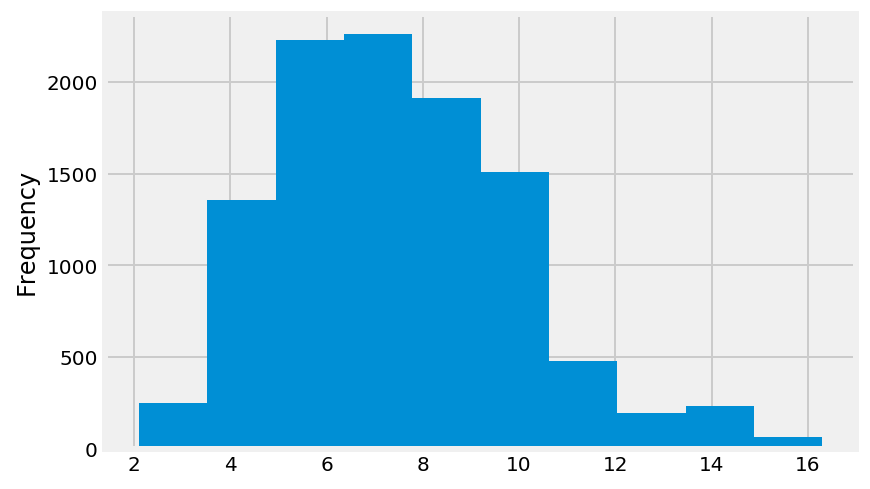

In [22]:
train['AvgSpeed'].plot(kind = 'hist')

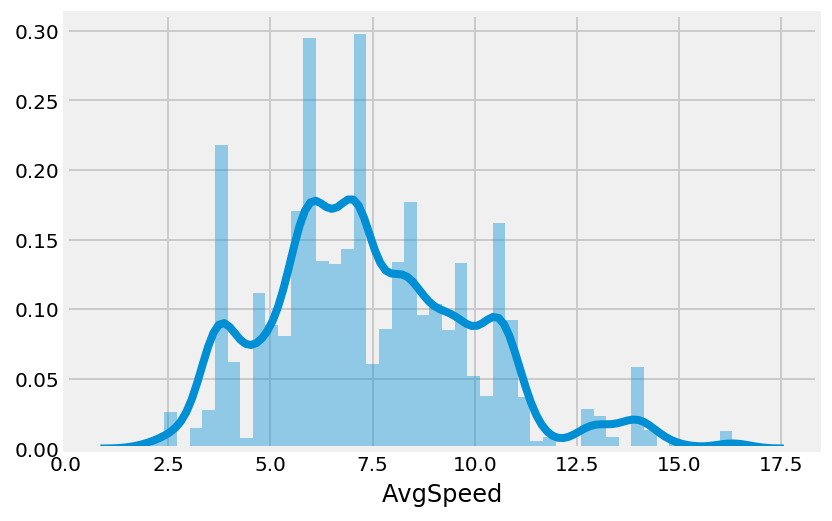

In [31]:
sns.distplot(train['AvgSpeed'])

In [24]:
train['WetBulb'].describe()

count    10480.000000
mean        64.901527
std          6.696082
min         46.000000
25%         61.000000
50%         66.000000
75%         70.000000
max         76.000000
Name: WetBulb, dtype: float64

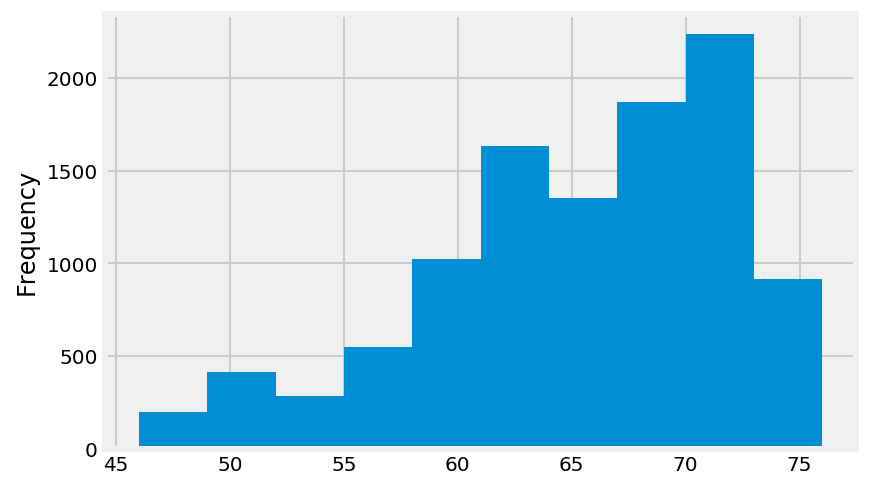

In [25]:
train['WetBulb'].plot(kind='hist')

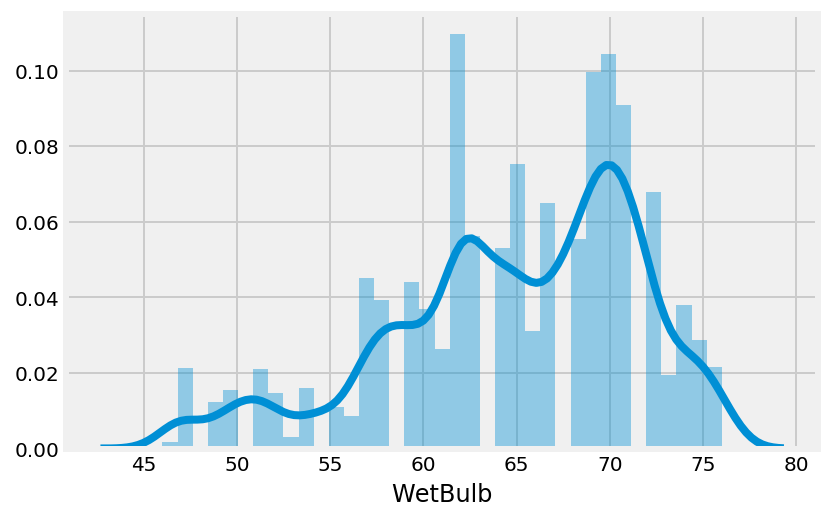

In [30]:
sns.distplot(train['WetBulb'])

In [27]:
train['PrecipTotal'].describe()

count    10480.000000
mean         0.128145
std          0.308325
min          0.000000
25%          0.000000
50%          0.000000
75%          0.080000
max          3.970000
Name: PrecipTotal, dtype: float64

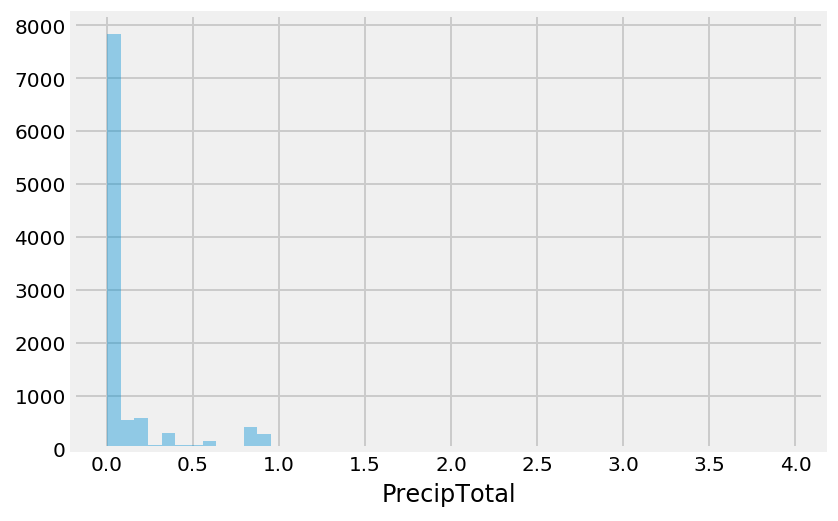

In [29]:
sns.distplot(train['PrecipTotal'], kde = False)

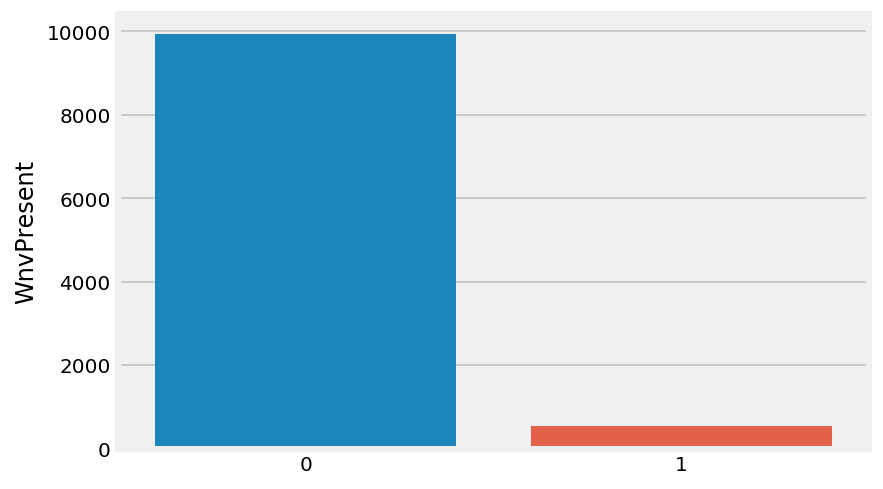

In [35]:
sns.barplot(x = [0,1], y = train['WnvPresent'].value_counts())

We have heavily unbalanced classes for our response variable, WnvPresent.

Our options include:

* Oversampling the WnvPresent == 1 class
* Bootstrapping
* Stratifying